# Assignment 3 

## Calculate position, velocity, and acceleration trajectories

Motion parameters: 
\begin{equation}
p = [q_0 , q_f, \dot q_{max}, \ddot q_{max}]
\end{equation}

We are going to calculate trajectories using triangular or trapezoidal profile.  
**Profile is triangular if** 
\begin{equation}
\sqrt{\Delta q . \ddot q_{max}} \leq \dot q_{max}
\end{equation}  
  
For acceleration and deceleration time: 

\begin{equation}
\tau = \frac{\dot q_{max}}{\ddot q_{max}} \\
\end{equation}  

Dwelling time for trapezoidal profile: 
\begin{equation}
T = \frac{\Delta{q}}{\dot q_{max}} \\
\Delta q = q_f - q_0 
\end{equation}

Position trajectory equation:  
![](Trapizoidal_profile.png)  
So we can use derivative to find velocity, and acceleration trajectory equations from position trajectory equation.

In [1]:
import numpy as np
from numpy import pi
from matplotlib.pyplot import *

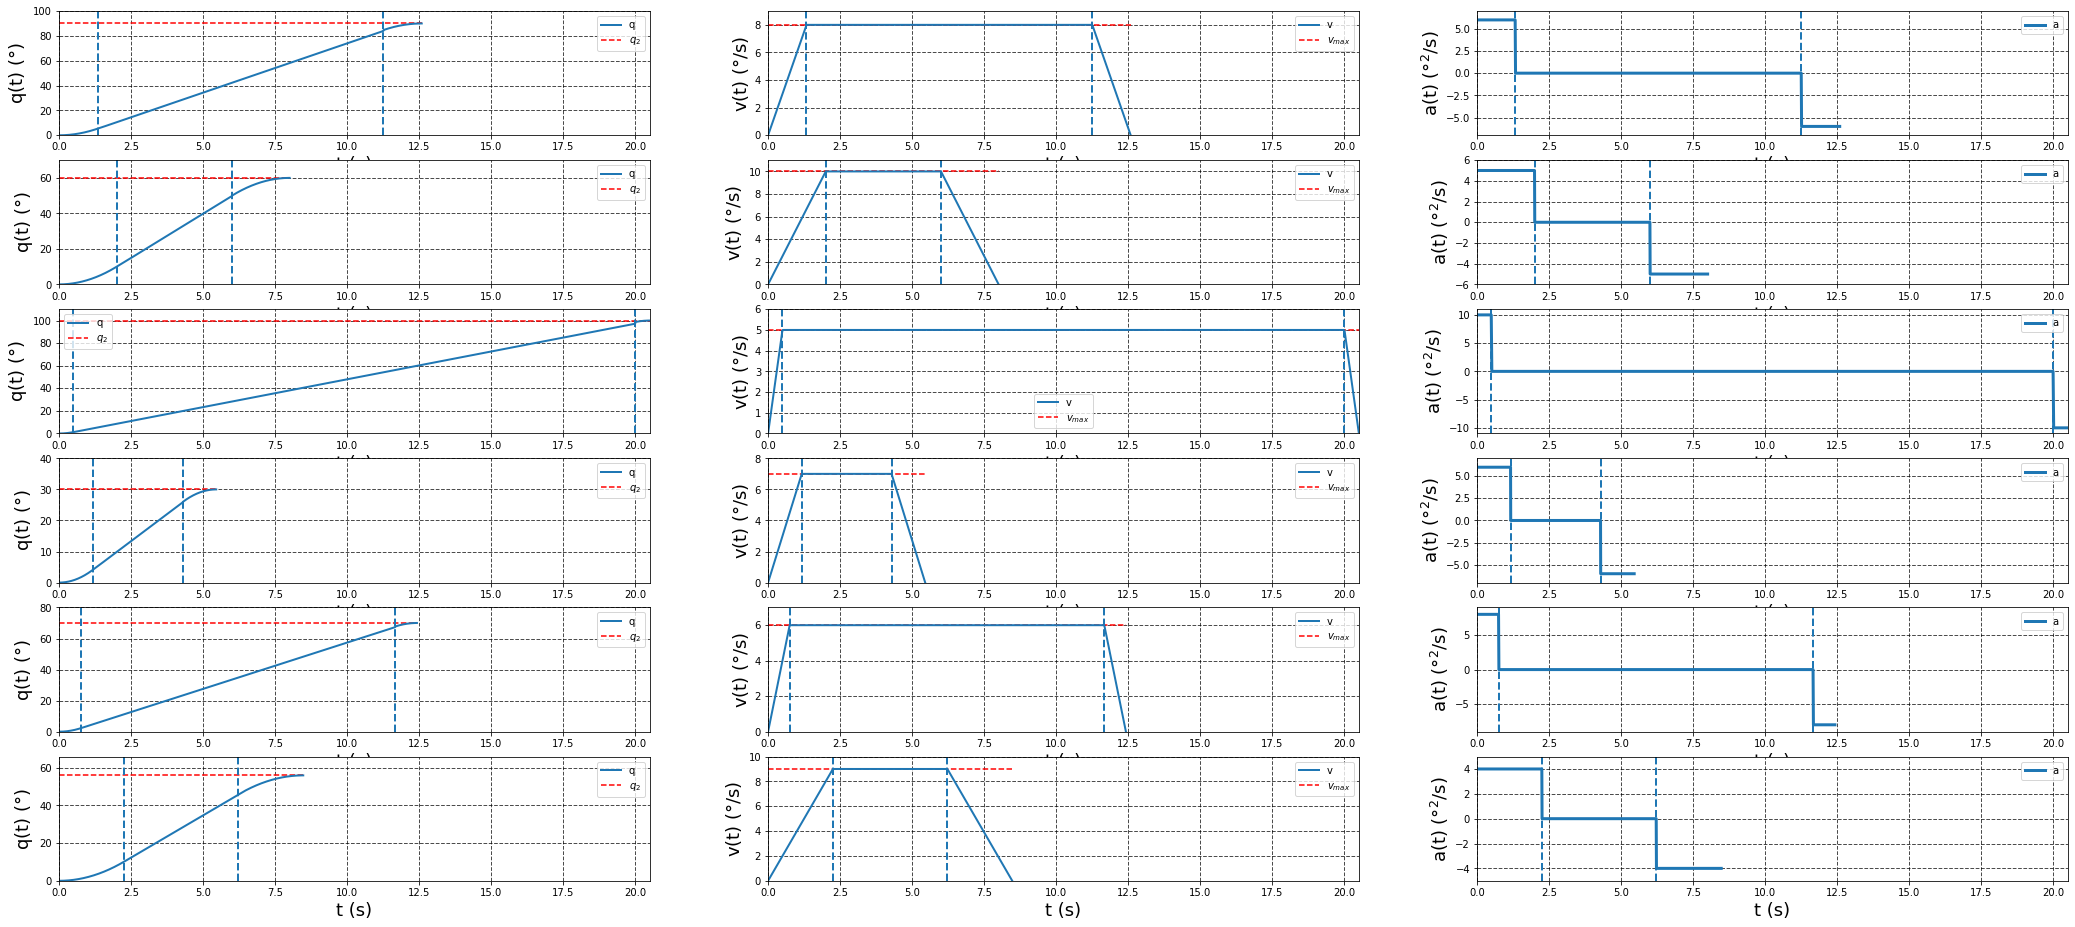

In [2]:
def trajectory_time(params, t0 = 0): 
  q0,qf,dq_m,ddq_m = params

  dq = qf-q0
  #triangular check 
  c = np.sqrt(abs(dq*ddq_m)) 

  if c <= dq_m: 
    t1 = np.sqrt(abs(dq/ddq_m))
    T = t1
    tf = 2*t1
  else: 
    t1 = dq_m/ddq_m
    T = dq/dq_m
    tf = T+t1 
  
  return t0, t1,T,tf 

def plan_trajectory(q_params, t_params):
  t0,t1,T,tf = t_params
  q0,qf,dq_m,ddq_m = q_params 
  t = np.linspace(0,tf, int(1000))
  q = []
  v = []
  a = []

  for i in t: 

    if i <=t1:
      qi = q0 + (0.5*ddq_m*(i-0)**2)
      q02 = qi
      vi = ddq_m*i
      v02 = vi 
      ai = ddq_m
      
    elif i > t1 and i <= T: 
      vi = dq_m
      qi =  q02 + v02*(i-t1)
      ai = 0 
      
    elif i > T: 
      vi = ddq_m*(tf-i)
      qi = qf - (0.5*ddq_m*(i-tf)**2)
      ai = -ddq_m

    q.append(qi)
    v.append(vi) 
    a.append(ai)

  t = np.linspace(t0,t0 + tf, int(1000))

  return t, q, v, a

def plot_joints(joints):

  tf_max = 0
  for i, joint in enumerate(joints):
    j_t = trajectory_time(joint)
    tf_max = max(tf_max, j_t[3])

  figure(figsize=(36,16))
  for i, joint in enumerate(joints):
    #calculate trajectory time for each
    j_t = trajectory_time(joint)
    #calculate each trajectory
    T,q,v,a = plan_trajectory(joint,j_t)
    #extract time params for plotting
    _,t_,T_,tf = j_t

    subplot(len(joints), 3, 3*i + 2)
    plot(T,v, linewidth=2, label="v")
    xlabel('t (s)', fontsize=18)
    ylabel(r'v(t) ($\degree$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf_max])
    ylim([0,max(v)+1])
    hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
    vlines([t_,T_], 0, max(q), linestyles='--', linewidth=2)
    legend()

    subplot(len(joints), 3, 3*i + 1)
    plot(T,q, linewidth=2, label="q")
    xlabel('t (s)', fontsize=18)
    ylabel(r'q(t) ($\degree$)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf_max])
    ylim([0,max(q)+10])
    hlines(joint[1], 0,tf, linestyles='--', color='r', label=r"$q_{2}$")
    vlines([t_,T_], 0, max(q)+10, linestyles='--', linewidth=2)
    legend()


    subplot(len(joints), 3, 3*i + 3)
    plot(T,a, linewidth=3, label="a")
    xlabel('t (s)', fontsize=18)
    ylabel(r'a(t) ($\degree^2$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf_max])
    ylim([min(a)-1,max(a)+1])
    vlines([t_,T_], min(a)-1, max(a)+1, linestyles='--', linewidth=2)
    legend()
  pass

# params [q0,qf,dq_m, ddq_m]
j1 = [0,90,8,6]
j2 = [0,60,10, 5]
j3 = [0,100,5,10]
j4 = [0,30,7,6]
j5 = [0,70,6,8]
j6 = [0,56,9,4]

plot_joints([j1,j2,j3,j4,j5,j6])

show()

## Synchronize joints

To synchonize joint we just should find the maximum time at each section and then recalculate velocity and acceleration for other joints.

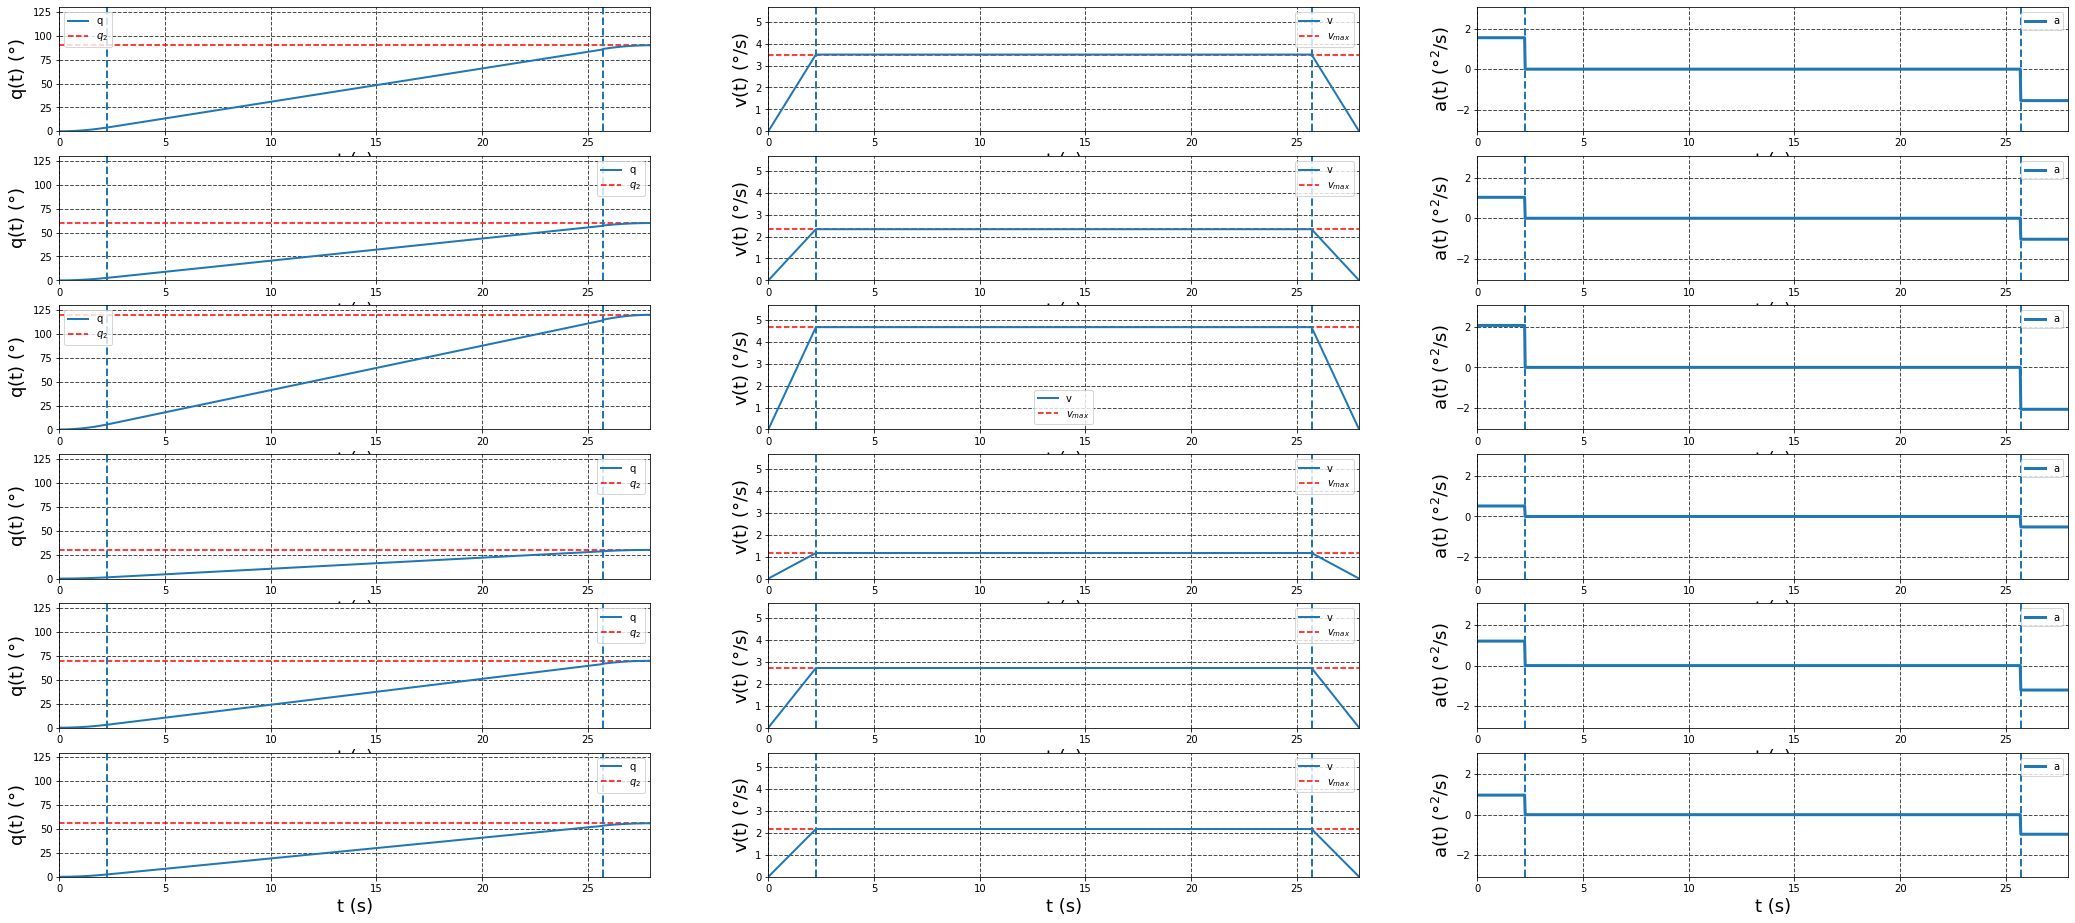

In [3]:
def plot_joints_with_synchronization(joints):
  t0 = 0
  tf_max = 0
  dwell = 0
  t1 = 0
  for joint in joints:
    j_t = trajectory_time(joint)
    tf_max = max(tf_max, j_t[3])
    t1 = max(t1, j_t[1])
    dwell = max(dwell, j_t[2] - j_t[1])

  T = dwell + t1
  tf = T + t1
  t_params = [t0,t1,T, tf]
  
  q_max, v_max, a_max = 0,0,0
  for joint in joints:
    dq_m = (joint[1]-joint[0])/T
    ddq_m = dq_m/t1
    joint[2:] = [dq_m, ddq_m]
    
    _,q,v,a = plan_trajectory(joint,t_params)
    q_max = max(q_max, max(q))
    v_max = max(v_max, max(v))
    a_max = max(a_max, max(a))

  figure(figsize=(36,16))
  for i, joint in enumerate(joints):
    T,q,v,a = plan_trajectory(joint,t_params)
    _,t_,T_,tf = t_params

    subplot(len(joints), 3, 3*i + 2)
    plot(T,v, linewidth=2, label="v")
    xlabel('t (s)', fontsize=18)
    ylabel(r'v(t) ($\degree$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf])
    ylim([0,v_max+1])
    hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
    vlines([t_,T_], 0, q_max, linestyles='--', linewidth=2)
    legend()

    subplot(len(joints), 3, 3*i + 1)
    plot(T,q, linewidth=2, label="q")
    xlabel('t (s)', fontsize=18)
    ylabel(r'q(t) ($\degree$)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf])
    ylim([0,q_max+10])
    hlines(joint[1], 0,tf, linestyles='--', color='r', label=r"$q_{2}$")
    vlines([t_,T_], 0, q_max+10, linestyles='--', linewidth=2)
    legend()


    subplot(len(joints), 3, 3*i + 3)
    plot(T,a, linewidth=3, label="a")
    xlabel('t (s)', fontsize=18)
    ylabel(r'a(t) ($\degree^2$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf])
    ylim([-a_max-1,a_max+1])
    vlines([t_,T_], -a_max-1, a_max+1, linestyles='--', linewidth=2)
    legend()
  pass

# params [q0,qf,dq_m, ddq_m]
j1 = [0,90,8,6]
j2 = [0,60,3,10]
j3 = [0,120,5,9]
j4 = [0,30,7,6]
j5 = [0,70,6,8]
j6 = [0,56,9,4]

plot_joints_with_synchronization([j1,j2,j3,j4,j5,j6])

show()

## Numerical control

Robot can send signals at discrete period of time. So we should recalculate our to trajectories. 

![](Numerical_control.png)

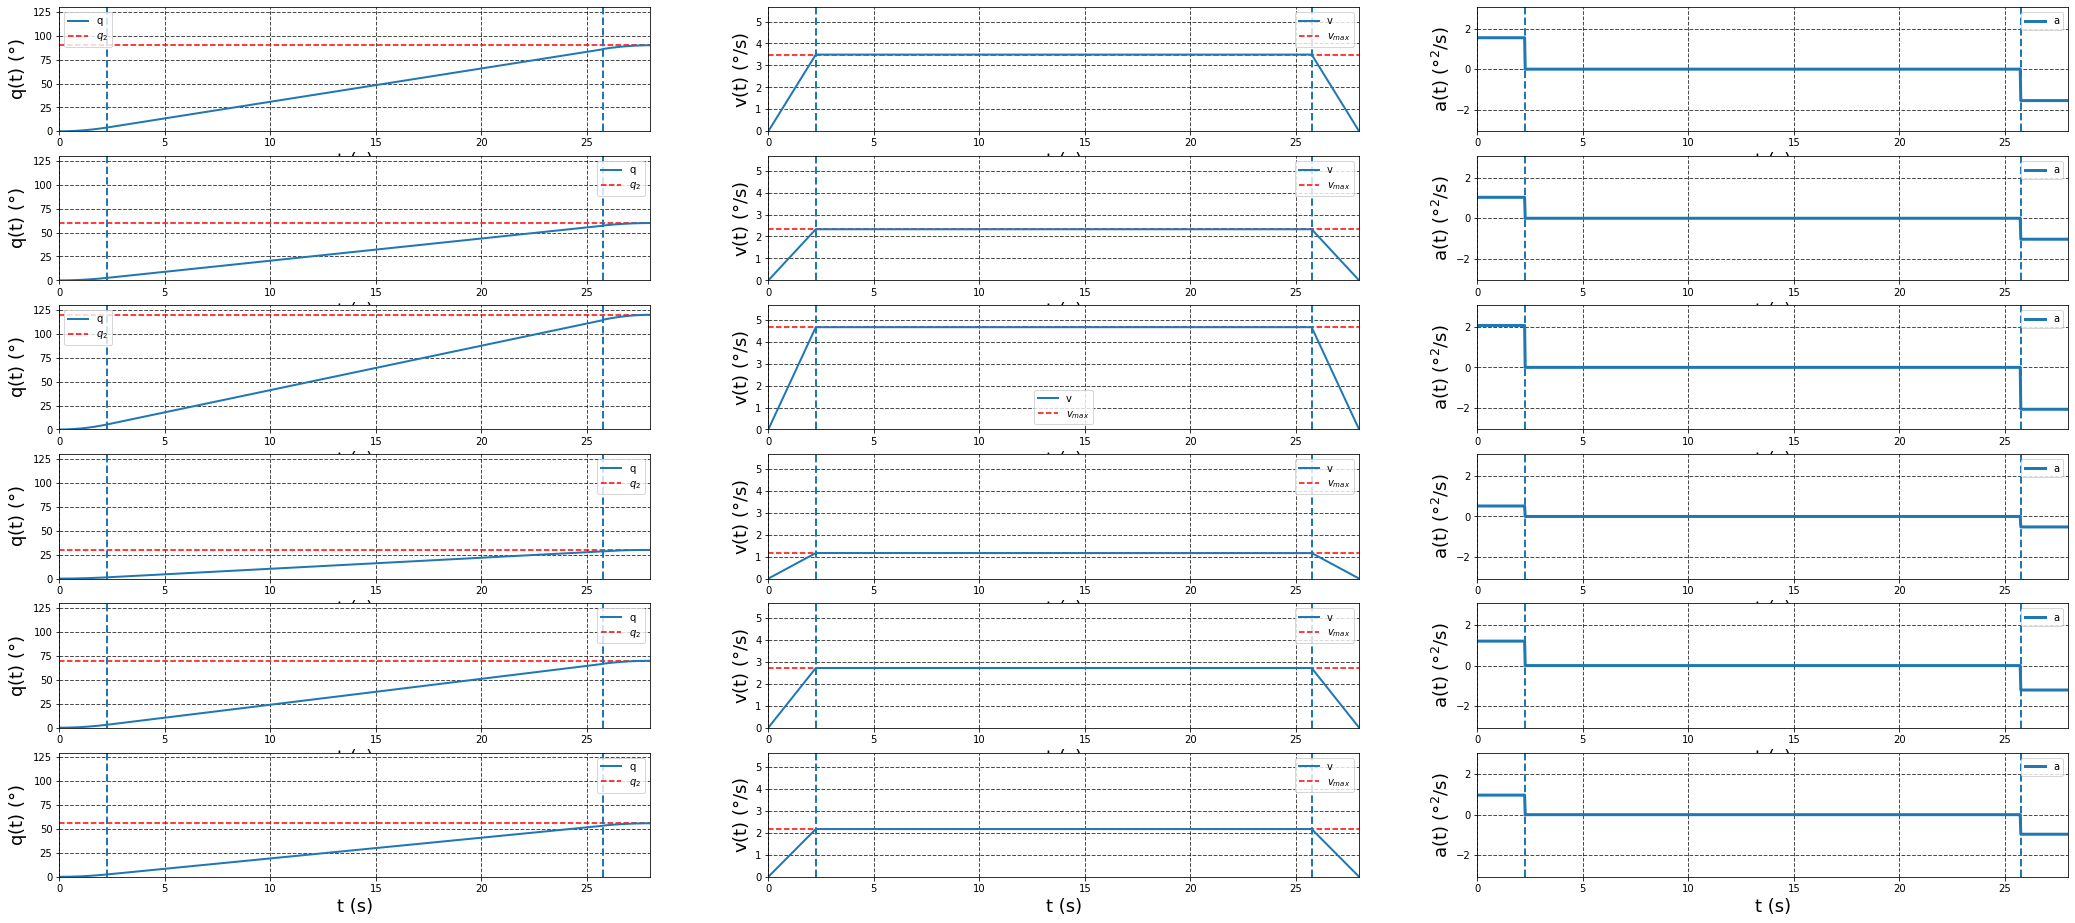

In [4]:
def plot_joints_with_synchronization_and_numerical_control(joints, freq = 0.05, t0=0):
  times = np.array([trajectory_time(joint, t0=t0) for joint in joints])
  t0_max, t1_max, T_max, tf_max = times.max(0)
  dwell = (times[:,2] - times[:,1]).max()
  T_max = t1_max + dwell
  
  #new times for normal control
  t1_modified = np.ceil(t1_max/freq) * freq
  T_modified = (np.ceil(T_max/freq) + 1) * freq
  tf_modified = t1_modified + T_modified
  t_params = [t0_max,t1_modified,T_modified, tf_modified]
  
  for joint in joints:
    dq_m = (joint[1]-joint[0])/T_modified
    ddq_m = dq_m/t1_modified
    joint[2:] = [dq_m, ddq_m]
  
  trajectories = [plan_trajectory(joint,t_params) for joint in joints]
  q_max = np.max([max(traj[1]) for traj in trajectories])
  v_max = np.max([max(traj[2]) for traj in trajectories])
  a_max = np.max([max(traj[3]) for traj in trajectories])

  figure(figsize=(36,16))
  for i, joint in enumerate(joints):
    T,q,v,a = plan_trajectory(joint,t_params)
    _,t_,T_,tf = t_params

    subplot(len(joints), 3, 3*i + 2)
    plot(T,v, linewidth=2, label="v")
    xlabel('t (s)', fontsize=18)
    ylabel(r'v(t) ($\degree$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([t0,t0 + tf])
    ylim([0,v_max+1])
    hlines(joint[2], t0,t0 + tf, linestyles='--', color='r', label=r"$v_{max}$")
    vlines([t_,T_], 0, q_max, linestyles='--', linewidth=2)
    legend()

    subplot(len(joints), 3, 3*i + 1)
    plot(T,q, linewidth=2, label="q")
    xlabel('t (s)', fontsize=18)
    ylabel(r'q(t) ($\degree$)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([t0,t0 + tf])
    ylim([0,q_max+10])
    hlines(joint[1], t0,t0 + tf, linestyles='--', color='r', label=r"$q_{2}$")
    vlines([t_,T_], 0, q_max+10, linestyles='--', linewidth=2)
    legend()


    subplot(len(joints), 3, 3*i + 3)
    plot(T,a, linewidth=3, label="a")
    xlabel('t (s)', fontsize=18)
    ylabel(r'a(t) ($\degree^2$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([t0,t0 + tf])
    ylim([-a_max-1,a_max+1])
    vlines([t_,T_], -a_max-1, a_max+1, linestyles='--', linewidth=2)
    legend()
  return T_modified

# params [q0,qf,dq_m, ddq_m]
j1 = [0,90,8,6]
j2 = [0,60,3,10]
j3 = [0,120,5,9]
j4 = [0,30,7,6]
j5 = [0,70,6,8]
j6 = [0,56,9,4]

plot_joints_with_synchronization_and_numerical_control([j1,j2,j3,j4,j5,j6])

show()

## Trajectory junction

When we follow several points consistently, we don't want to lose our velocity, so we want to do it smoothly.

![](Trajectory_junction.png)

In [5]:
from joint import Joint

j1 = Joint([0, 90, 60, 100], dq_max=8, ddq_max=6)
j2 = Joint([0, 60, 30, 80], 3, 10)
j3 = Joint([0, 100, 120, 90], 5, 9)
j4 = Joint([0, 30, 60, 90], 7, 6)
j5 = Joint([0, 70, 40, 10], 6, 8)
j6 = Joint([0, 56, 30, 80], 9, 4)
joints = [j1, j2, j3, j4, j5, j6]

Points:
         №|         t|         q|         v
         0|     0.000|     0.000|     0.000
         1|     3.000|     9.000|     6.000
         2|    15.000|    81.000|     6.000
         3|    18.000|    82.500|    -5.000
         4|    21.000|    67.500|    -5.000
         5|    24.000|    66.667|     4.444
         6|    30.000|    93.333|     4.444
         7|    33.000|   100.000|     0.000


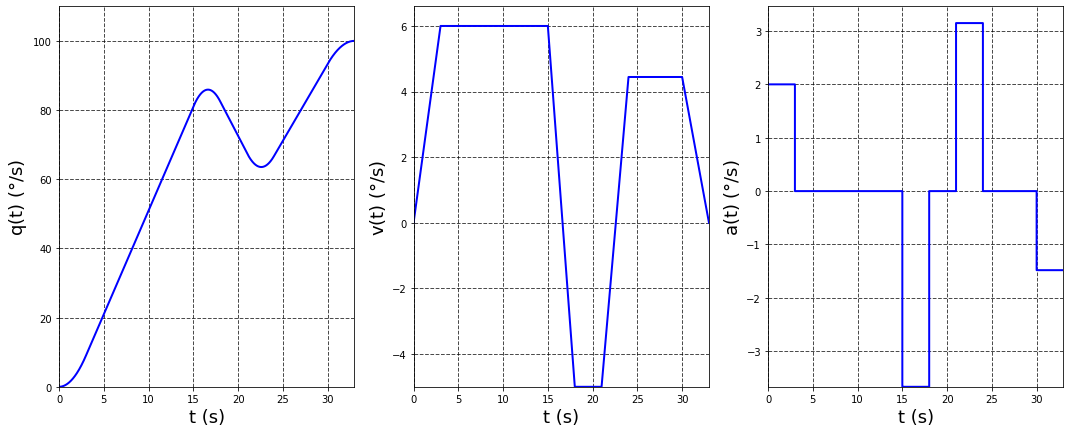

Points:
         №|         t|         q|         v
         0|     0.000|     0.000|     0.000
         1|     3.000|     3.750|     2.500
         2|    24.000|    56.250|     2.500
         3|    27.000|    57.000|    -2.000
         4|    39.000|    33.000|    -2.000
         5|    42.000|    33.571|     2.381
         6|    60.000|    76.429|     2.381
         7|    63.000|    80.000|     0.000


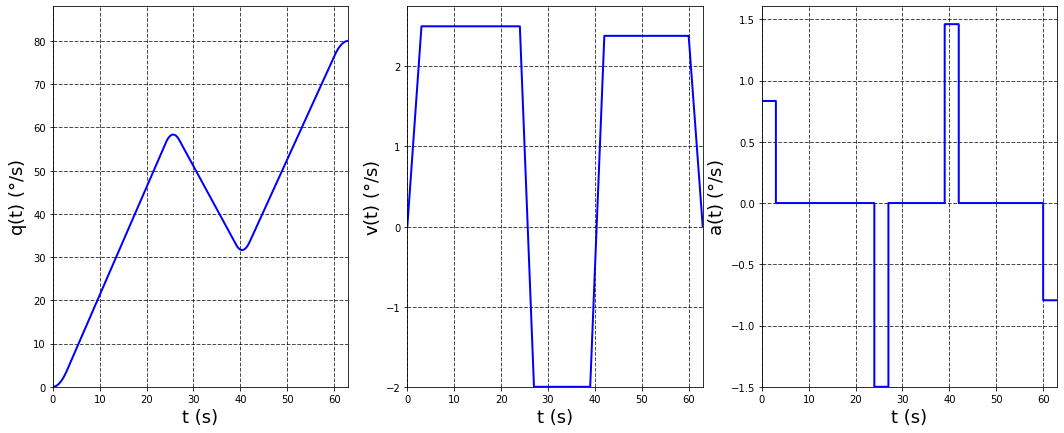

Points:
         №|         t|         q|         v
         0|     0.000|     0.000|     0.000
         1|     3.000|     6.250|     4.167
         2|    24.000|    93.750|     4.167
         3|    27.000|   103.333|     2.222
         4|    33.000|   116.667|     2.222
         5|    36.000|   115.000|    -3.333
         6|    42.000|    95.000|    -3.333
         7|    45.000|    90.000|     0.000


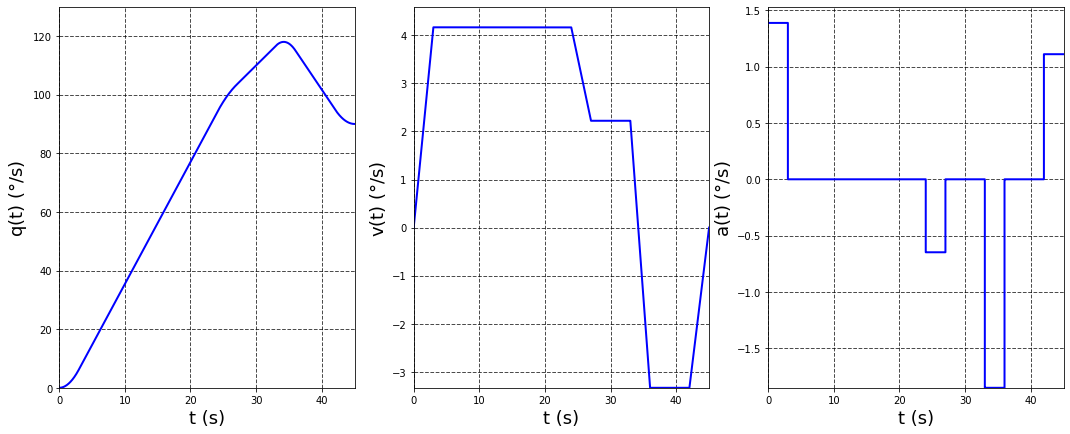

Points:
         №|         t|         q|         v
         0|     0.000|     0.000|     0.000
         1|     3.000|     5.000|     3.333
         2|     9.000|    25.000|     3.333
         3|    12.000|    35.000|     3.333
         4|    18.000|    55.000|     3.333
         5|    21.000|    65.000|     3.333
         6|    27.000|    85.000|     3.333
         7|    30.000|    90.000|     0.000


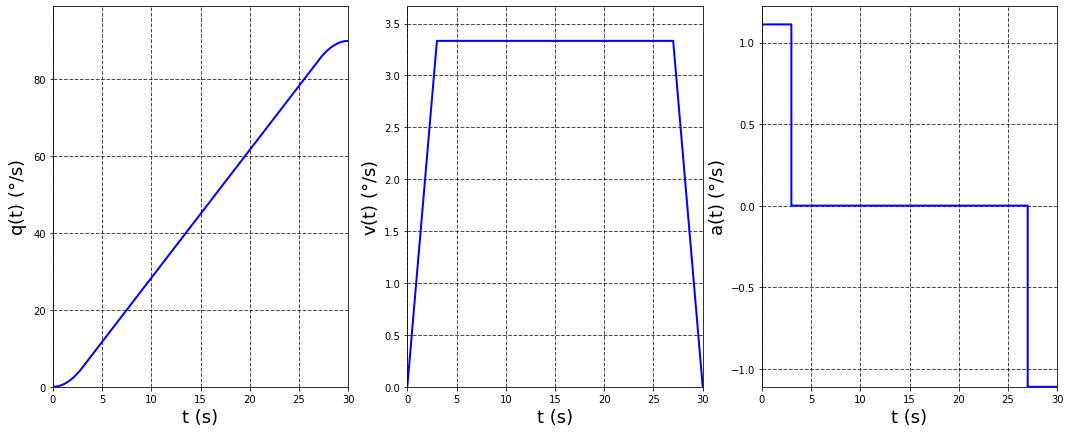

Points:
         №|         t|         q|         v
         0|     0.000|     0.000|     0.000
         1|     3.000|     7.000|     4.667
         2|    15.000|    63.000|     4.667
         3|    18.000|    65.000|    -3.333
         4|    24.000|    45.000|    -3.333
         5|    27.000|    35.000|    -3.333
         6|    33.000|    15.000|    -3.333
         7|    36.000|    10.000|     0.000


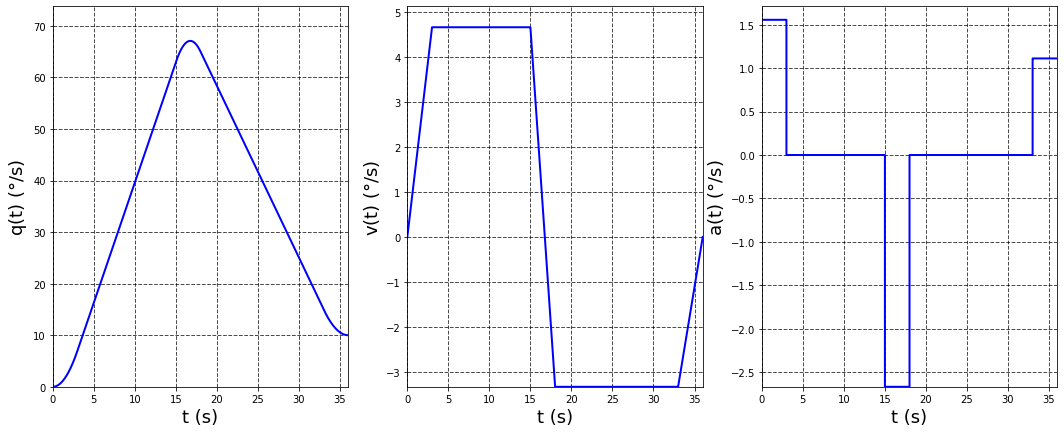

Points:
         №|         t|         q|         v
         0|     0.000|     0.000|     0.000
         1|     3.000|     9.333|     6.222
         2|     9.000|    46.667|     6.222
         3|    12.000|    49.500|    -4.333
         4|    15.000|    36.500|    -4.333
         5|    18.000|    38.333|     5.556
         6|    24.000|    71.667|     5.556
         7|    27.000|    80.000|     0.000


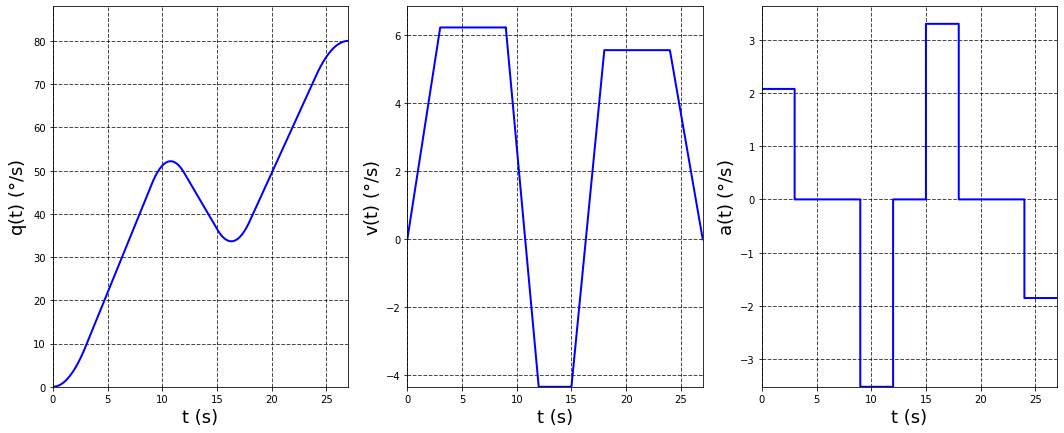

In [6]:
for joint in joints:
    joint.trajectory_junction_ratio = 1
    joint.calculate_path()
    joint.numerical_control()
    joint.plot_path_points(print_points=True)